In [12]:
import numpy as np
import pandas as pd
import warnings
from scipy.sparse.linalg import eigs
from scipy.linalg import eig 

# 读取feature和target, 不制指定表头
df_fea = pd.read_excel('wine.xlsx',header = None)
df_gnd = pd.read_excel('wine_labels.xlsx',header = None)

# 对fea进行0-1归一化
# 与matlab数据对比过相同
df_fea = (df_fea-df_fea.min())/(df_fea.max()-df_fea.min())

# 将feature和target转换成ndarray类型加速计算
fea = np.array(df_fea)
gnd = np.array(df_gnd)

# 定义option字典, 类比matlab中的结构体
options = {
    'Metric':'Euclidean',
    'NeighborMode':'KNN',
    'k':10,
    'bSelfConnected':1,
    'delta':1000,
    'WeightMode':'HeatKernel',
    't':1,
    'ReducedDim':3
}

class KMFA():
    def __init__(self, fea, gnd, options):
        self.fea = fea
        self.gnd = gnd
        self.options = options
        
    def norm(self, na):
        return np.sqrt(sum(na**2))
        
    
    def constructW1(self):
        delta = self.options['delta'] # 核参数
        nSmp, nfea = self.fea.shape[0], self.fea.shape[1]
        D = np.zeros((nSmp,nSmp))
        K = np.zeros((nSmp,nSmp))
        # 非监督核欧式距离
        for i in range(nSmp-1):
            for j in range(i+1, nSmp):
                K[i][j] = np.exp(-self.norm(fea[i,:]-fea[j,:])**2/delta)
                d = np.sqrt(2-2*K[i][j])
                D[i][j] = np.sqrt(np.exp(-d**2/0.1))
        D = (D+D.T)/2
        # 构建近邻无向图
        G = np.zeros((nSmp,nSmp))
        idx = np.argsort(D,axis = 0,kind='heapsort') # 升序排序
        for i in range(nSmp):
            nNonzero = len([i for i in D[:,i] if i != 0])
            idx[:,i][:nSmp-nNonzero] = sorted(idx[:,i][:nSmp-nNonzero])
        for i in range(nSmp):
            # 和样本i最近的k+1个样本为1
            G[i,idx[i,0:self.options['k']+1]] = 1
            # 近邻样本之间为1 非近邻为0
        if not self.options['bSelfConnected']:
            for i in range(nSmp):
                G[i][i] = 0
        # 构建近邻链接权重矩阵W
        D2 = np.exp(-D**2/self.options['t']) #计算每个样本的相似度
        W = D2*G #近邻样本之间为相似度为D 非近邻为0
        
        return W,K
        
        
        
    def constructWW1(self):
        delta = self.options['delta'] # 核参数
        k = self.options['k'] # 近邻数
        nSmp, nfea = self.fea.shape[0], self.fea.shape[1]
        D = np.zeros((nSmp,nSmp))
        for i in range(nSmp-1):
            for j in range(i+1, nSmp):
                d = np.sqrt(2-2*np.exp(-self.norm(fea[i,:]-fea[j,:])**2/delta))
                if self.gnd[i] == self.gnd[j]:
                    D[i,j] = np.sqrt(1-np.exp(-d**2/10))
                else:
                    D[i,j] = np.sqrt(np.exp(-d**2/10))
        # 构建近邻无向图
        G1 = np.zeros((nSmp,nSmp))
        G2 = np.zeros((nSmp,nSmp))
        idx = np.argsort(D,axis = 0,kind='heapsort') # 升序排序
        
        # 这块是个坑, 转换matlab和python过程中排序序号变的问题
        for i in range(nSmp):
            nNonzero = len([i for i in D[:,i] if i != 0])
            idx[:,i][:nSmp-nNonzero] = sorted(idx[:,i][:nSmp-nNonzero])
  
        pd.DataFrame(idx).to_csv('idx.csv', index = None, columns = None)
        # 寻找异类边界流行
        for i in range(nSmp):
            a = 0
            for j in range(nSmp):
                if a<=k+1 and gnd[idx[i,j]] != gnd[i]:
                    a += 1
                    G1[i,idx[i,j]] = 1
        for i in range(nSmp):
            a = 0
            for j in range(nSmp):
                if a <= k+1 and gnd[idx[i,j]] == gnd[i]:
                    a += 1
                    G2[i,idx[i,j]] = 1
        
        D1 = np.exp(-D**2/delta)
        w1 = D1*G1
        w2 = D1*G2
        
        return w1, w2
    
    
    def KMFA_calc(self):
        W, K = self.constructW1()
        W1, W2 = self.constructWW1()
        nSmp, nFea = self.fea.shape[0], self.fea.shape[1]
        # 要求特征数大于样本数
        if nFea > nSmp:
            warnings.warn('X is not of full rank in column!!')
        if 'ReducedDim' not in options:
            ReducedDim = nFea
        else:
            ReducedDim = self.options['ReducedDim']
        if ReducedDim > nFea:
            ReducedDim = nFea
        
        D1 = np.diag(np.sum(W1, axis = 0))
        
        D2 = np.diag(np.sum(W2, axis = 0))
        L1 = D1 - W1
        L2 = D2 - W2
        # L2没问题
        DPrime = K@L2@K
        DPrime = (DPrime+DPrime.T)/2
        
        LPrime = K@L1@K
        LPrime = (LPrime+LPrime.T)/2    
        dimMatrix = DPrime.shape[1]
#         pd.DataFrame(LPrime).to_csv('LPrime.csv',index=None)

        # using eigs to speed up!
        if dimMatrix > 100 and ReducedDim < dimMatrix/2:
            eigvalue, eigvector = eigs(A = LPrime,M = DPrime, k = ReducedDim, which = 'LR', v0=np.ones(nSmp))
            eigvalue = np.diag(eigvalue)
            
        else:
            eigvalue, eigvector = eig(LPrime, DPrime)
            eigvalue = np.abs(eigvalue)
            # eigvalue = np.diag(eigvalue)
            # eigvalue从大到小
            idx = np.argsort(eigvalue)
            eigvalue = eigvalue[idx]
            eigvector = eigvector[:,idx]

        if ReducedDim < eigvector.shape[1]:
            eigvector = eigvector[:, 0:ReducedDim]
            eigvalue = eigvalue[:ReducedDim]
        
        for i in range(eigvector.shape[1]):
            eigvector[:,i] = eigvector[:,i]/self.norm(eigvector[:,i])
        # 最终映射矩阵
        Y = K @ eigvector.real
        
        return Y
    
k = KMFA(fea, gnd, options)
Y = k.KMFA_calc()

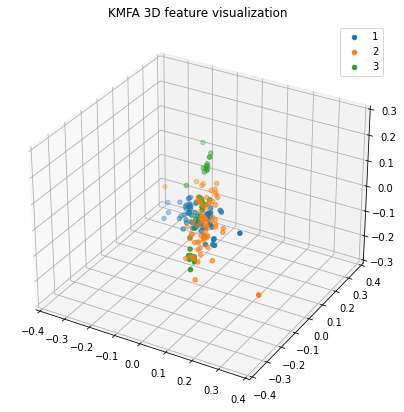

In [13]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
 
# Creating dataset
x, y, z = Y[:,0].reshape(len(gnd),1),Y[:,1].reshape(len(gnd),1),Y[:,2].reshape(len(gnd),1)
 
# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
# Set the bound of the x,y,z three axis
plt.xlim([-0.4,0.4])
plt.ylim([-0.4,0.4])
ax.set_zlim(-0.3,0.3)

# Creating plot
for i in range(1,np.max(gnd)+1):
    ax.scatter3D(x[gnd == i], y[gnd == i], z[gnd == i], label = str(i))
    plt.title("KMFA 3D feature visualization")

plt.legend()
plt.show()

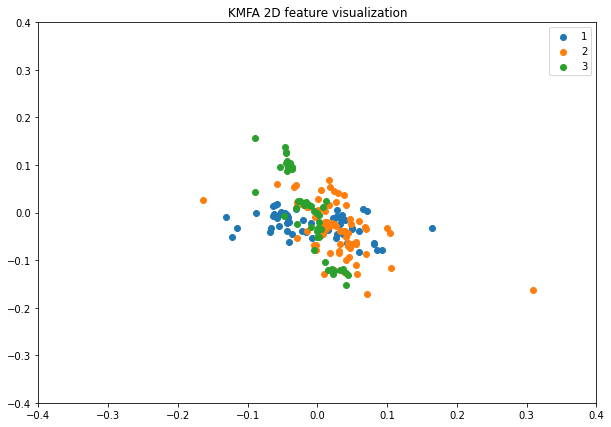

In [14]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
 
# Creating dataset
x, y, z = Y[:,0].reshape(len(gnd),1),Y[:,1].reshape(len(gnd),1),Y[:,2].reshape(len(gnd),1)
 
# Creating figure
fig = plt.figure(figsize=(10, 7))
# Set the bound of the x,y,z three axis
plt.xlim([-0.4,0.4])
plt.ylim([-0.4,0.4])

# Creating plot
for i in range(1,np.max(gnd)+1):
    plt.scatter(x[gnd == i], y[gnd == i], label = str(i))
    plt.title("KMFA 2D feature visualization")

plt.legend()
plt.show()

In [10]:
pd.DataFrame(Y).to_csv('Y.csv',index=None)